In [23]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

In [24]:
class FANET:
    def __init__(self, size):
        self.size = size
        #self.start_point = (0, 0, 0)
        self.reward_map = {
            'terminal' : 1,
            'hazard' : -10,
            'base station' : 0
        }
        self.map_point = {
            'terminal zone' : {'start' : (90, 90, 90), 'end' : self.size, 'reward' : self.reward_map['terminal']},
            'hazard 1': {'start': (0, 20, 55), 'end': (0, 20, 55), 'reward' : self.reward_map['hazard']},
            'hazard 2': {'start': (30, 30, 0), 'end': (30, 60, 60), 'reward' : self.reward_map['hazard']},
            'hazard 3': {'start': (20, 0, 0), 'end': (40, 20, 50), 'reward' : self.reward_map['hazard']},
            'hazard 4': {'start': (60, 60, 0), 'end': (95, 95, 80), 'reward' : self.reward_map['hazard']},
            'base station' : {'start' : (0, 0, 0), 'end' : (1, 1, 1), 'reward' : self.reward_map['base station']}
        }
        self.grid_map = self.map()
        self.reset()
        
    def reset(self):
        self.state = self.set_start_zone()
        
    def map(self):
        grid = -1 * np.ones(self.size, dtype=np.float32)
        
        for zone in self.map_point.values():
            start = zone['start']
            end = zone['end']
            reward = zone['reward']
            grid[start[0]:end[0]+1, start[1]:end[1]+1, start[2]:end[2]+1] = reward
            
        return grid
    
    def reward(self):
        x, y, z = self.state
        
        if self.grid_map[x, y, z] == self.map_point['hazard 1']['reward']:   # hazard zone
            reward = self.reward_map['hazard']
        elif self.grid_map[x, y, z] == self.map_point['terminal zone']['reward']:    # terminal zone
            reward = self.reward_map['terminal']
        else:
            reward = -1
        
        return reward
    
    def step(self, action):
        x, y, z = self.state
        
        if action == 0 and x < self.size[0] - 1:
            x += 1
        elif action == 1 and x > 0:
            x -= 1
        elif action == 2 and y < self.size[1] - 1:
            y += 1
        elif action == 3 and y > 0:
            y -= 1
        elif action == 4 and z < self.size[2] - 1:
            z += 1
        elif action == 5 and z > 0:
            z -= 1
            
        self.state = (x, y, z)
        reward = self.reward()
        
        return self.state, reward, self.grid_map[x, y, z] == self.map_point['terminal zone']['reward']
    
    def set_start_zone(self):
        x = np.random.randint(0, self.size[0])
        y = np.random.randint(0, self.size[0])
        z = 0
        
        while self.grid_map[x, y, z] == -10 or self.grid_map[x, y, z] == 1:
                x = np.random.randint(0, self.size[0])
                y = np.random.randint(0, self.size[0])
                z = 0
                
        return (x, y, z)

In [25]:
class FourierEstimator:
    def __init__(self, env, n, alpha):
        self.n = n                                  # Fourier order
        self.k = 3                                  # State Dimension (x, y)
        self.n_action = 6                           # number of actions
        self.alpha = alpha                          # base learning rate
        self.w = np.zeros([pow(self.n+1, self.k), self.n_action])
        self.env = env
        self.alpha_vec = self.setting_alphas()
        
    def setting_alphas(self):
        orders = list(range(self.n + 1))            # orders {0, 1, ..., n}
        c = list(product(orders, repeat = self.k))  # (n+1)^k Cartesian Products
        norm_c = np.linalg.norm(c, axis = 1)        # (n+1)^k norms
        norm_c[0] = 1.
        return self.alpha / norm_c                  # shape ((n+1)^k)
    
    def normalize(self, state):
        norm_state = np.empty(np.shape(state))
        min_state = np.array([0, 0, 0])                         # Minimun Start Zone (0,0)
        max_state = np.array([self.env.size[0], self.env.size[1], self.env.size[2]]) # Maximum Size
        
        state_range = max_state - min_state
        norm_state = (state - min_state) / state_range
        
        return norm_state
    
    def get_features(self, state):
        norm_state = self.normalize(state)
        orders = list(range(self.n + 1))             # orders {0, 1, ..., n} 
        c = list(product(orders, repeat=self.k))     # (n+1)^k Cartesian products
        return np.cos(np.pi * np.dot(c, norm_state)) # (n+1)^k features
    
    def predict_values(self, state):
        return np.dot(self.w.T, self.get_features(state))
    
    def update_weights(self, state, action, target):
        q_values = self.predict_values(state)
        current_q = q_values[action]
        delta = target - current_q
        features = self.get_features(state)
        self.w[:, action] += delta * self.alpha_vec * features

In [26]:
class QAgent():
    def __init__(self, env, estimator, gamma, epsilon, num_episodes):
        self.env = env
        self.estimator = estimator
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        
    def get_action(self, state):
        if np.random.rand(1) < self.epsilon:
            values = np.random.randint(6)
        else:
            values = np.argmax(self.estimator.predict_values(state))
        return values

    def semi_gradient_qlearning(self):
        conflict_count = []
        store_path = []
        
        for episode in tqdm(range(self.num_episodes)):
            self.env.reset()
            state = self.env.state
            step_count = 0
            stop = False
            path = [state]
            
            #for _ in tqdm(range(100*100)):
            while not stop:
                action = self.get_action(state)
                next_state, reward, stop = self.env.step([0, 1, 2, 3, 4, 5][action])
                path.append(next_state)
                
                if reward == -10:
                    step_count += 1

                if stop:
                    target = reward
                else:
                    next_action = np.argmax(self.estimator.predict_values(next_state))
                    target = reward + self.gamma * self.estimator.predict_values(next_state)[next_action]

                self.estimator.update_weights(state, action, target)

                if stop:
                    break
                elif len(path) >= 100 * 100:
                    break

                state = next_state
                action = next_action
                
            conflict_count.append(step_count)
            store_path.append(path)
            #print(f'{episode}/{self.num_episodes}, 충돌횟수 : {conflict_count[episode]}')
            
        return conflict_count, store_path

In [27]:
env = FANET((100,100,100))
estimator = FourierEstimator(env, n=6, alpha=0.01)
agent = QAgent(env, estimator, gamma=0.99, epsilon=0.01, num_episodes=1000)

conflict_count, path = agent.semi_gradient_qlearning()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:02<00:00,  1.84it/s]


In [28]:
def visualize_3d(path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    hazard_indices = np.where(env.grid_map == -10)
    terminal_indices = np.where(env.grid_map == 1)
    ax.scatter(*hazard_indices, c='r', marker='s', label='Hazard Zone')
    ax.scatter(*terminal_indices, c='g', marker='s', label='Terminal Zone')
    
    x, y, z = np.array(path).T
    ax.plot(x, y, z, '-o', label='Path')

    ax.set_xlim(0, env.size[0])
    ax.set_ylim(0, env.size[1])
    ax.set_zlim(0, env.size[2])

    ax.legend()
    
    plt.show()
    
def visualize_2d(path):
    hazard_indices = np.where(env.grid_map == -10)
    terminal_indices = np.where(env.grid_map == 1)

    plt.scatter(*hazard_indices[:2], c='r', marker='s', label='Hazard Zone')
    plt.scatter(*terminal_indices[:2], c='g', marker='s', label='Terminal Zone')

    x, y, _ = np.array(path).T
    plt.plot(x, y, '-o', label='Path')

    plt.xlim(0, env.size[0])
    plt.ylim(0, env.size[1])
    plt.grid(True)

    plt.legend()

    plt.show()

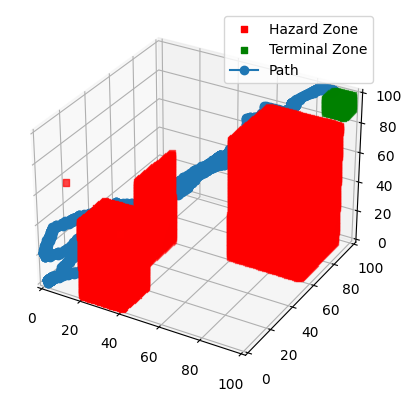

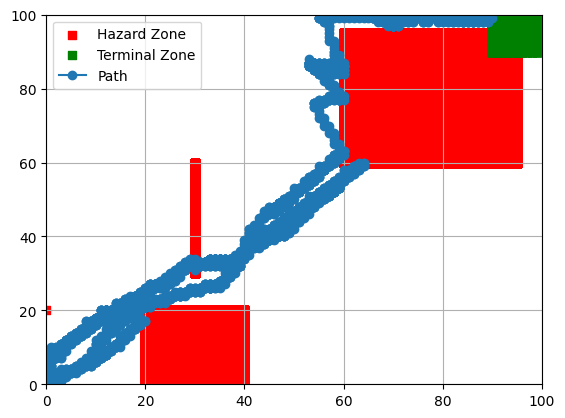

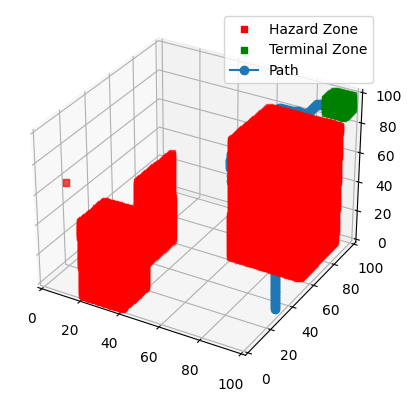

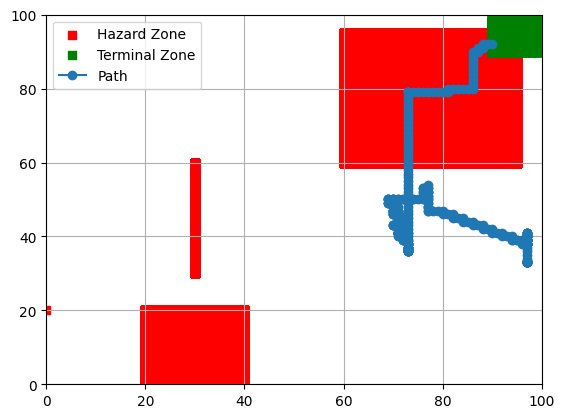

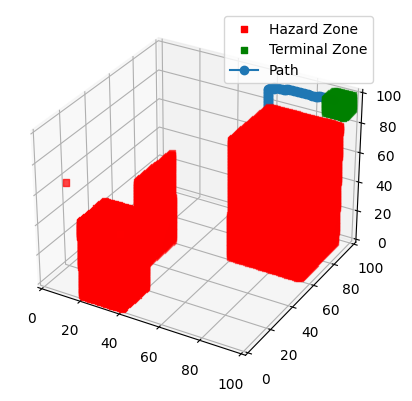

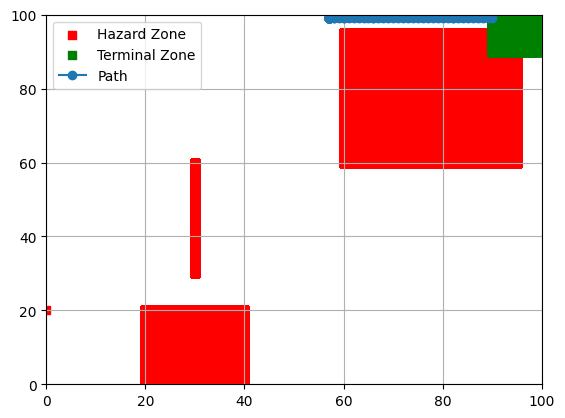

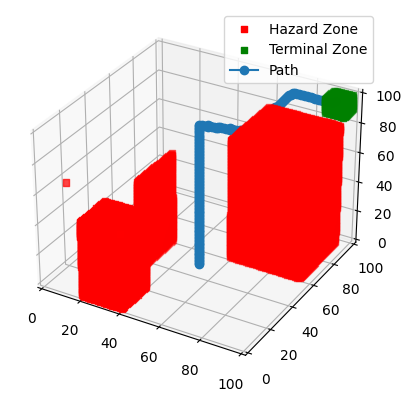

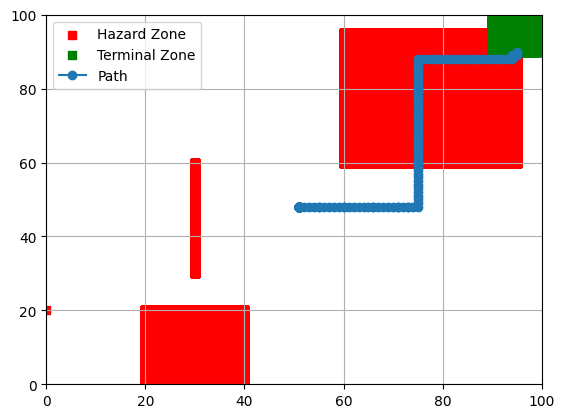

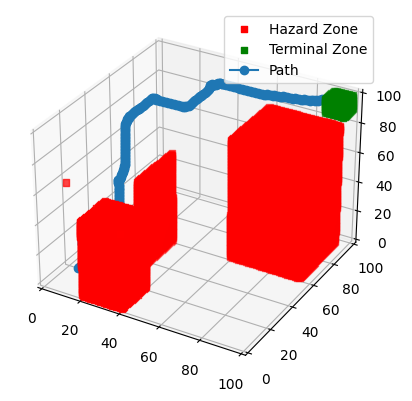

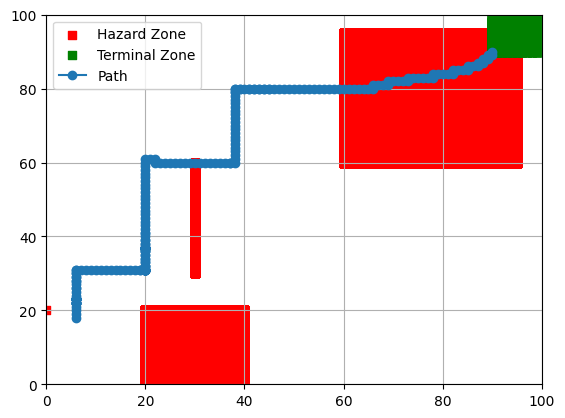

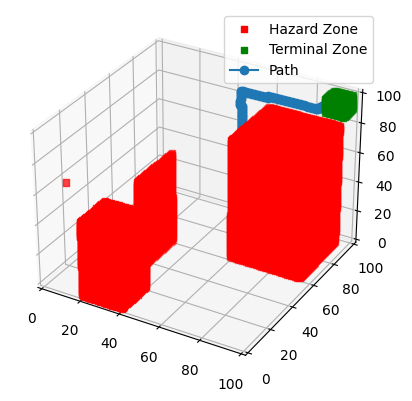

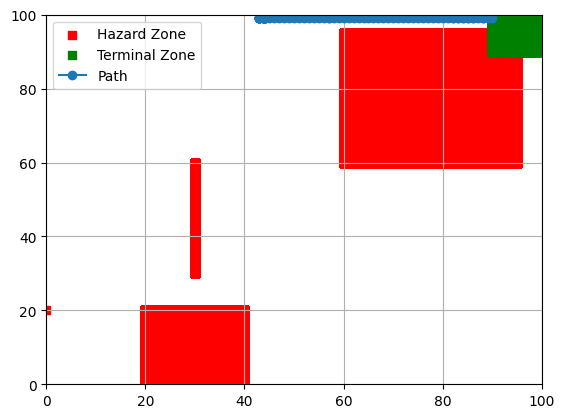

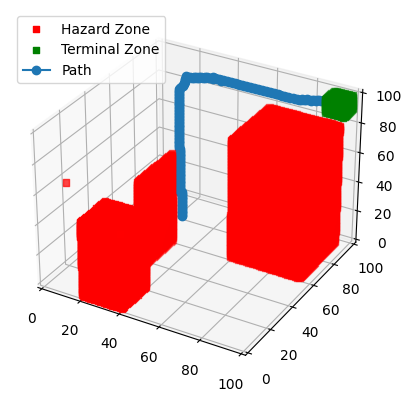

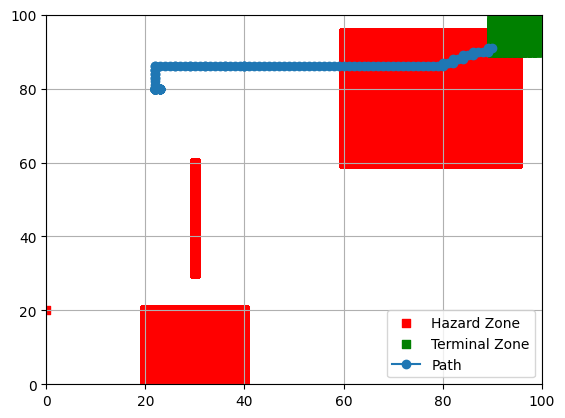

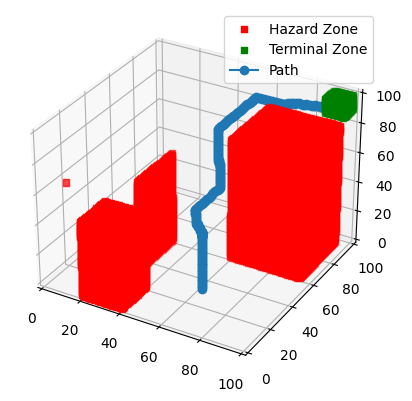

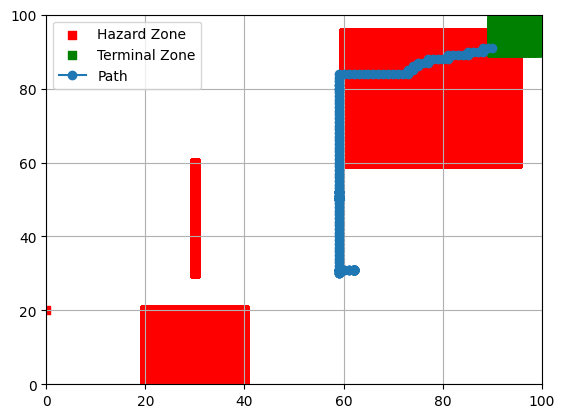

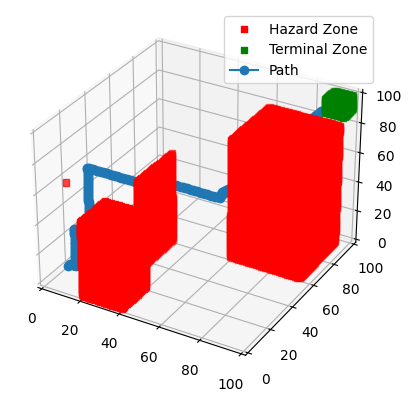

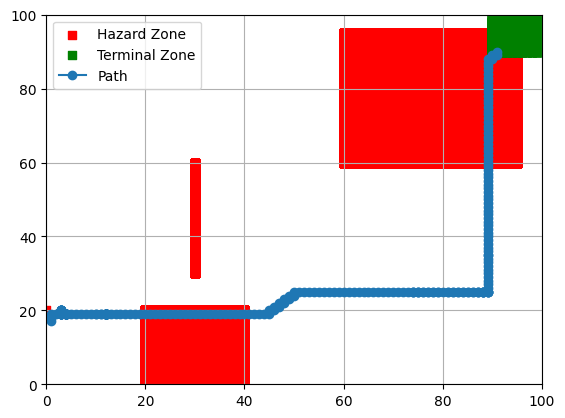

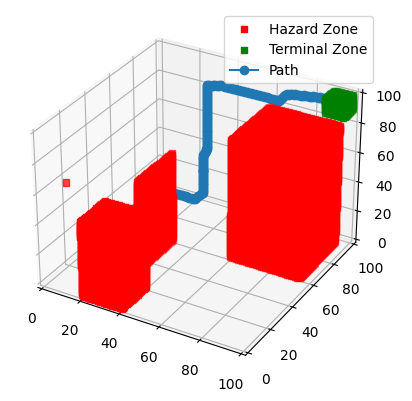

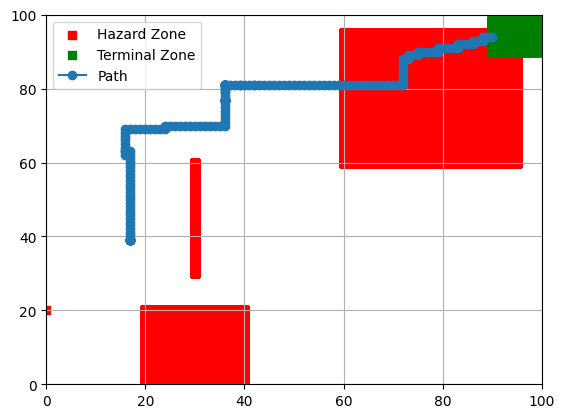

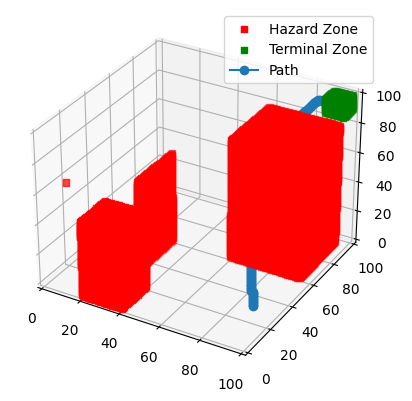

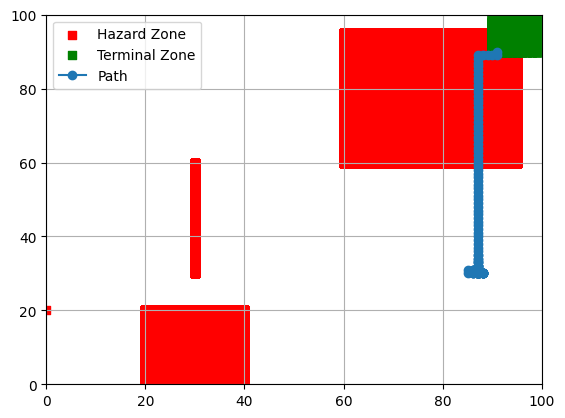

In [37]:
for i in range(0, 1000, 100):
    visualize_3d(path[i])
    visualize_2d(path[i])
    
visualize_3d(path[-1])
visualize_2d(path[-1])

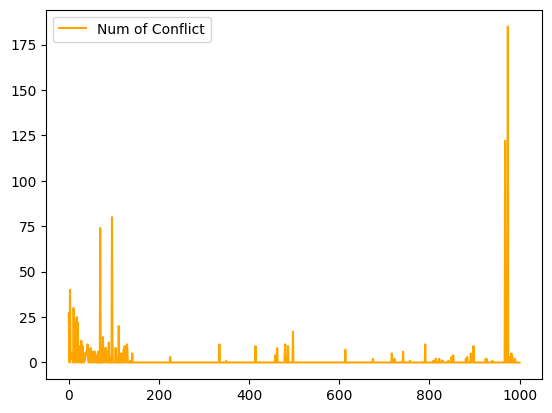

In [33]:
plt.plot(np.linspace(0, 1000, 1000), conflict_count, color='orange', label = 'Num of Conflict')
plt.legend()
plt.show()

In [34]:
for i in range(len(conflict_count)):
    if conflict_count[i] == 0:
        print('First Total Conflict equals zero is', i, 'episodes')
        break

First Total Conflict equals zero is 2 episodes
